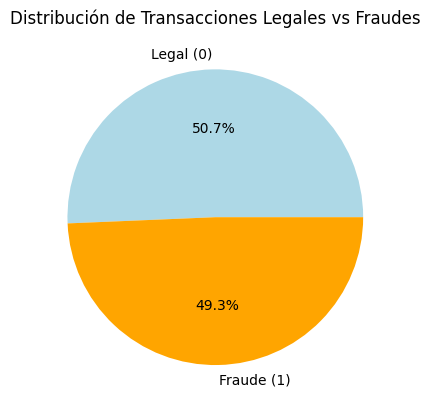

In [1]:
# MODULO 1: CARGA Y VISUALIZACIÓN DE DATOS

import pandas as pd
import matplotlib.pyplot as plt

# Cargar la base de datos
data = pd.read_csv('fraudes.csv', sep=';')

# Contar la cantidad de instancias para cada clase
class_counts = data["Class"].value_counts()

# Etiquetas para el gráfico
labels = ['Legal (0)', 'Fraude (1)']

# Dibujar el gráfico tipo pie
fig, ax = plt.subplots()
ax.pie(class_counts, labels=labels, autopct='%1.1f%%', colors=['lightblue', 'orange'])
ax.set_title('Distribución de Transacciones Legales vs Fraudes')

# Mostrar el gráfico
plt.show()

# Agrupar los datos por la columna 'Class' y sumar
grouped_data = data.groupby("Class").sum()

# Renombrar los índices 0 y 1 a 'Legal' y 'Fraude'
grouped_data.index = grouped_data.index.map({0: 'Legal', 1: 'Fraude'})



Número de componentes para capturar el 70% de la varianza: 6
Número de componentes para capturar el 80% de la varianza: 9
Número de componentes para capturar el 90% de la varianza: 12


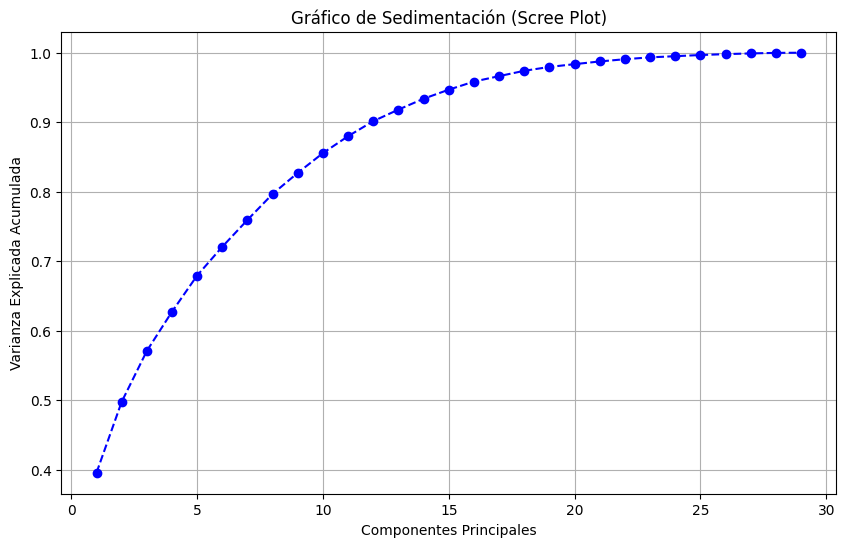

Bernoulli Naive Bayes:
Accuracy: 0.8493
Precision: 0.9815
Recall: 0.7162
F1-Score: 0.8281
AUC: 0.9241
Matriz de Confusión:
[[142   2]
 [ 42 106]]

Perceptrón Multicapa:
Accuracy: 0.6541
Precision: 0.3465
Recall: 0.2365
F1-Score: 0.2811
AUC: 0.9644
Matriz de Confusión:
[[ 78  66]
 [113  35]]


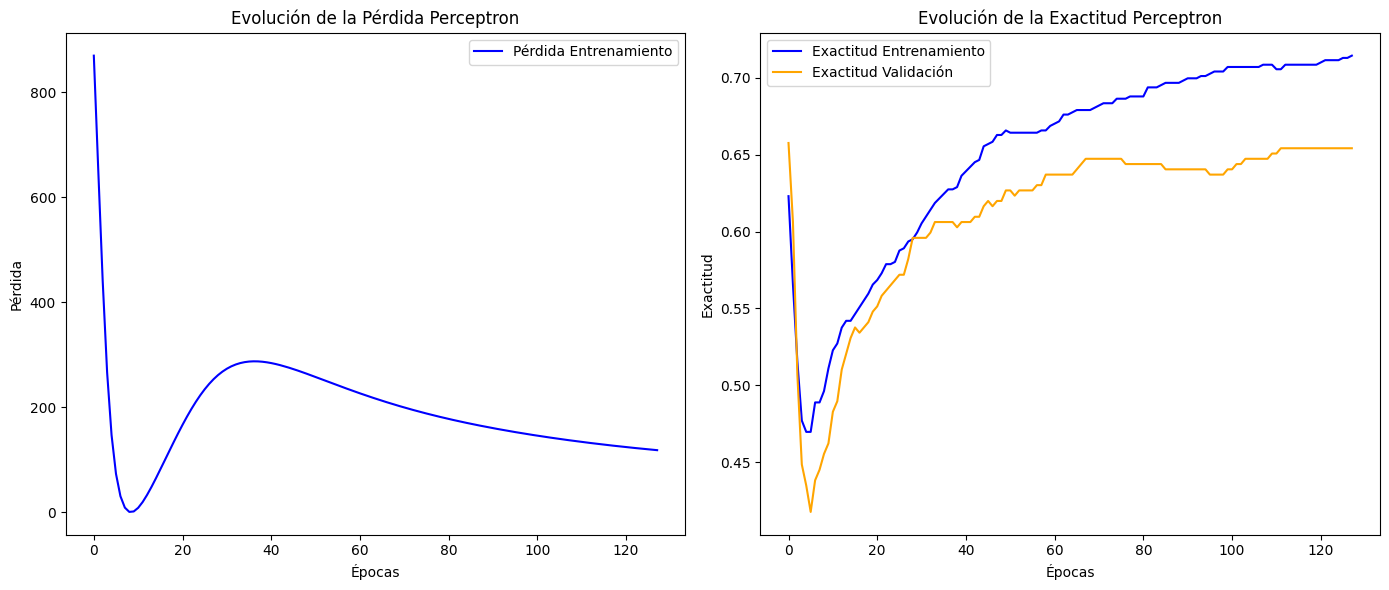

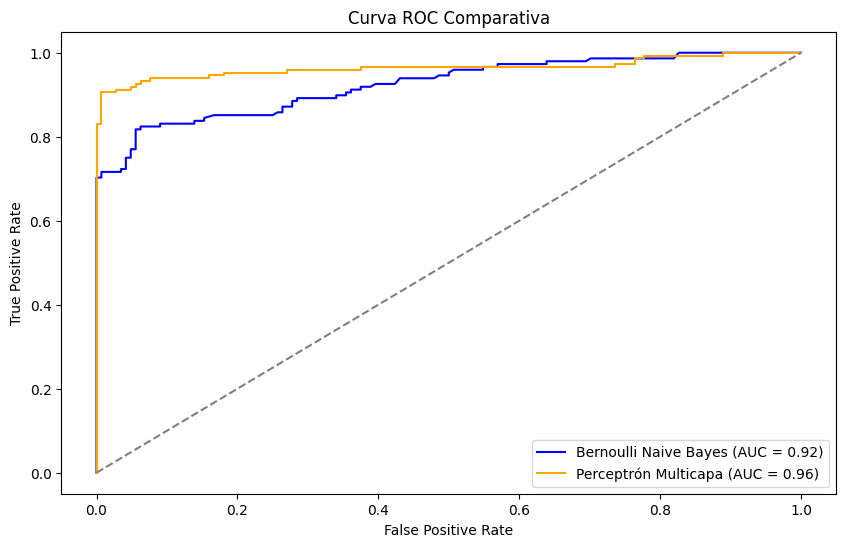

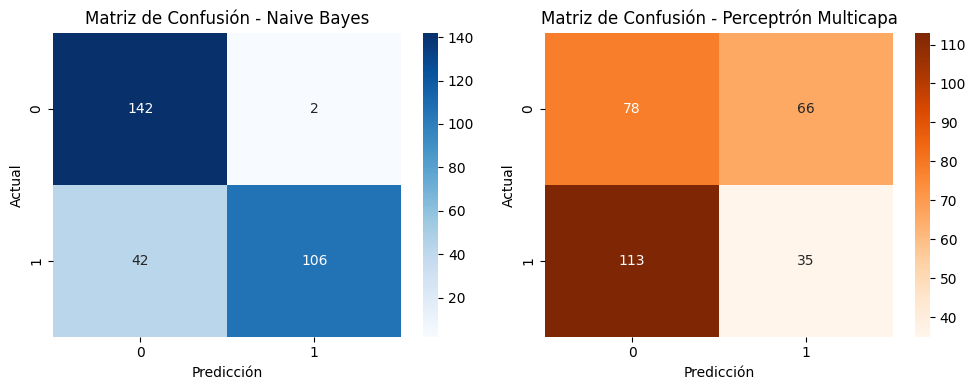

In [2]:
# Módulo 2: Evaluación de Modelos con Método de Componentes Principales (Bernoulli y Perceptrón)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
from nn import PerceptronMulticapa
from sklearn.metrics import roc_curve

# Cargar los datos
data = pd.read_csv("fraudes.csv", sep=';')

# Separar las características (sin incluir 'Class')
X = data.drop(columns=['Class'])
y = data['Class']

# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA()
pca.fit(X_scaled)

# Calcular la varianza explicada acumulada
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Identificar el número de componentes necesarios para capturar el 70%, 80% y 90% de la varianza
components_70 = (cumulative_variance >= 0.70).argmax() + 1
components_80 = (cumulative_variance >= 0.80).argmax() + 1
components_90 = (cumulative_variance >= 0.90).argmax() + 1

print(f"Número de componentes para capturar el 70% de la varianza: {components_70}")
print(f"Número de componentes para capturar el 80% de la varianza: {components_80}")
print(f"Número de componentes para capturar el 90% de la varianza: {components_90}")

# Gráfico de Sedimentación
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Gráfico de Sedimentación (Scree Plot)')
plt.xlabel('Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid(True)
plt.show()

# Parametrizar el número de componentes a usar (cambiar según se desee: components_70, components_80, components_90)
n_components = components_90

# Reducir la dimensionalidad de los datos
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, stratify=y, random_state=42)

# Bernoulli Naive Bayes
model_nb = BernoulliNB()
model_nb.fit(X_train, y_train)

# Hacer predicciones y evaluar
y_pred_nb = model_nb.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)
auc_nb = roc_auc_score(y_test, model_nb.predict_proba(X_test)[:, 1])
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Mostrar resultados Bernoulli Naive Bayes
print("Bernoulli Naive Bayes:")
print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1-Score: {f1_nb:.4f}")
print(f"AUC: {auc_nb:.4f}")
print("Matriz de Confusión:")
print(conf_matrix_nb)

# Perceptrón Multicapa
mlp = PerceptronMulticapa(features=n_components, hidden=32)

# Crear listas para guardar la evolución de la pérdida y la exactitud
train_losses = []
train_accuracies = []
val_accuracies = []

epochs = 128
for i in range(epochs):
    for j in range(X_train.shape[0]):
        mlp.forward(X_train[[j]], y_train.to_numpy().reshape(-1, 1)[[j]])
        mlp.backward(X_train[[j]], y_train.to_numpy().reshape(-1, 1)[[j]])
    output, probs, accuracy, L = mlp.predict(X_train, y_train.to_numpy().reshape(-1, 1))
    train_losses.append(L)
    train_accuracies.append(accuracy)

    # Evaluación en los datos de validación
    _, _, val_accuracy, _ = mlp.predict(X_test, y_test.to_numpy().reshape(-1, 1))
    val_accuracies.append(val_accuracy)

# Evaluar el modelo Perceptrón Multicapa
output_mlp, probs_mlp, accuracy_mlp, _ = mlp.predict(X_test, y_test.to_numpy().reshape(-1, 1))
precision_mlp = precision_score(y_test, output_mlp)
recall_mlp = recall_score(y_test, output_mlp)
f1_mlp = f1_score(y_test, output_mlp)
auc_mlp = roc_auc_score(y_test, probs_mlp[:, 1])
conf_matrix_mlp = confusion_matrix(y_test, output_mlp)

# Mostrar métricas finales en la consola
print("\nPerceptrón Multicapa:")
print(f"Accuracy: {accuracy_mlp:.4f}")
print(f"Precision: {precision_mlp:.4f}")
print(f"Recall: {recall_mlp:.4f}")
print(f"F1-Score: {f1_mlp:.4f}")
print(f"AUC: {auc_mlp:.4f}")
print("Matriz de Confusión:")
print(conf_matrix_mlp)

# Gráficos de la evolución de la pérdida y la exactitud
plt.figure(figsize=(14, 6))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, color='blue', label='Pérdida Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida Perceptron')
plt.legend()

# Gráfico de la exactitud
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, color='blue', label='Exactitud Entrenamiento')
plt.plot(range(epochs), val_accuracies, color='orange', label='Exactitud Validación')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.title('Evolución de la Exactitud Perceptron')
plt.legend()

plt.tight_layout()
plt.show()

# Curvas ROC
fpr_nb, tpr_nb, _ = roc_curve(y_test, model_nb.predict_proba(X_test)[:, 1])
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, probs_mlp[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_nb, tpr_nb, label='Bernoulli Naive Bayes (AUC = {:.2f})'.format(auc_nb), color='blue')
plt.plot(fpr_mlp, tpr_mlp, label='Perceptrón Multicapa (AUC = {:.2f})'.format(auc_mlp), color='orange')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Comparativa')
plt.legend()
plt.show()

# Matrices de Confusión
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sb.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Naive Bayes')
plt.xlabel('Predicción')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sb.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión - Perceptrón Multicapa')
plt.xlabel('Predicción')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


Variables seleccionadas después de la eliminación basada en correlación:
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V28', 'Amount', 'Class']
Bernoulli Naive Bayes
Accuracy Score:  0.9041
Precision: 1.0000
Recall: 0.8108
F1-Score: 0.8955
AUC: 0.9691
Matriz de Confusión:
[[144   0]
 [ 28 120]]

Perceptrón Multicapa:
Accuracy Score: 0.9418
Precision: 0.9781
Recall: 0.9054
F1-Score: 0.9404
AUC: 0.9806
Matriz de Confusión:
[[141   3]
 [ 14 134]]


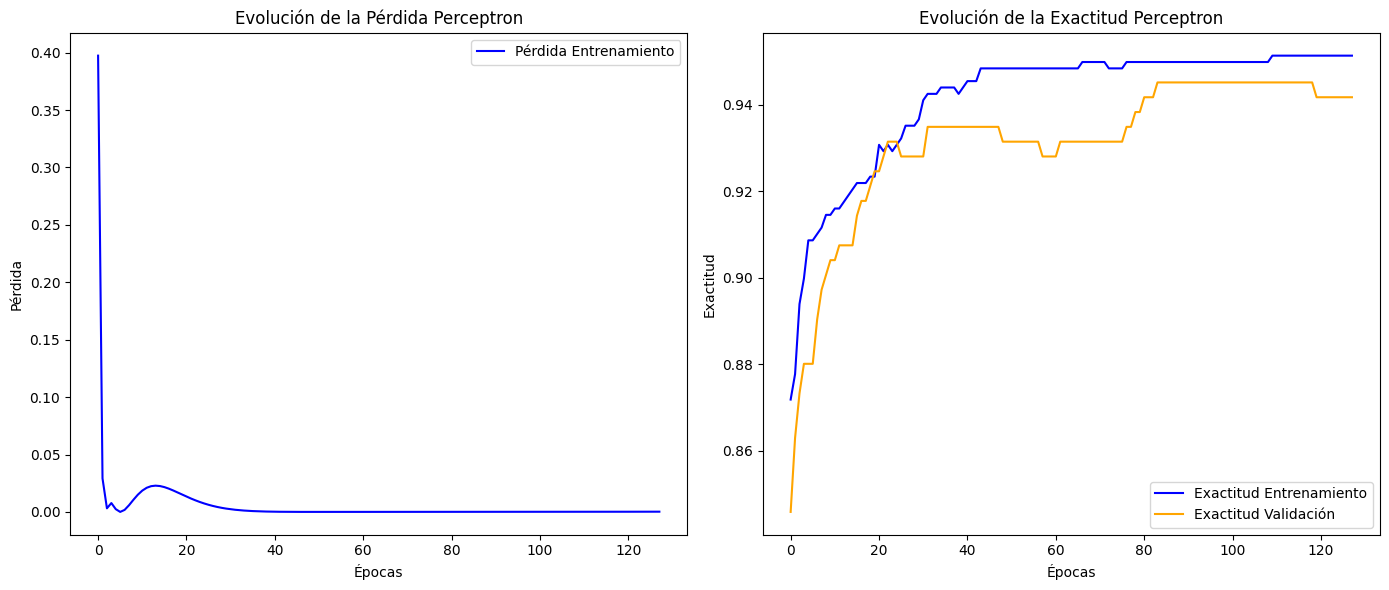

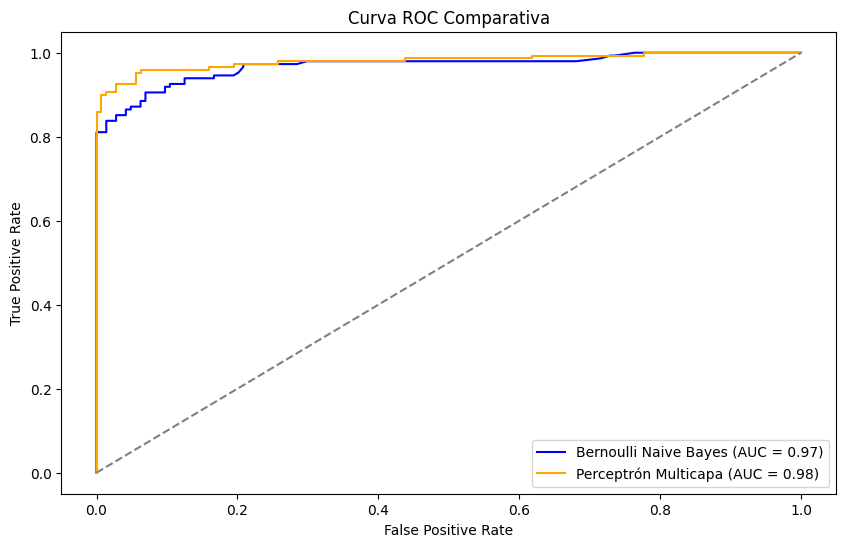

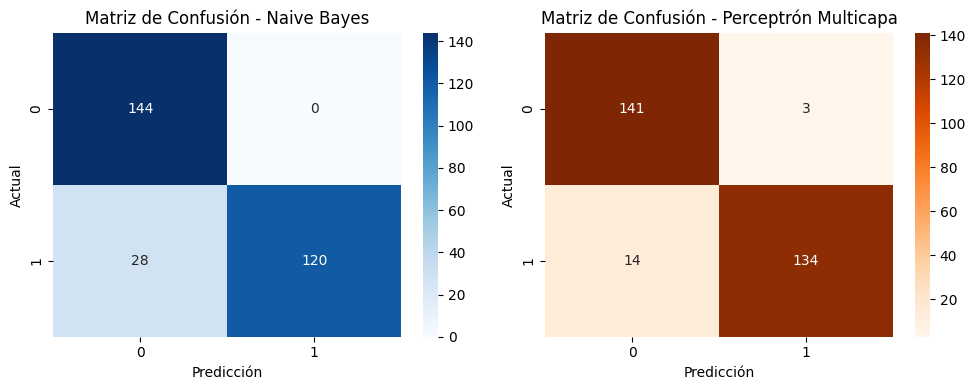

In [3]:
# Módulo 3: Evaluación de Modelos con Método de Correlación (Bernoulli y Perceptrón)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sb
from nn import PerceptronMulticapa

# Paso 1: Cargar los datos y seleccionar las variables relevantes
data = pd.read_csv("fraudes.csv", sep=';')

# Calcular la matriz de correlación
corr_matrix = data.corr()

# Seleccionar variables con baja correlación con la variable objetivo
threshold = 0.1  # Bajo este umbral la variable se descarta
low_corr_vars = corr_matrix['Class'][corr_matrix['Class'].abs() < threshold].index.tolist()

# Eliminar variables con baja correlación con la variable objetivo
data_reduced = data.drop(columns=low_corr_vars)

# Mostrar las variables seleccionadas
print(f"Variables seleccionadas después de la eliminación basada en correlación:\n{data_reduced.columns.tolist()}")

# Paso 2: Preparar los datos para entrenamiento
X = data_reduced.drop(columns=['Class']).values
y = data_reduced['Class'].values

# Estandarizar las características
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convertir las etiquetas a one-hot encoding para el Perceptrón Multicapa
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train_onehot, X_test_onehot, y_train_onehot, y_test_onehot = train_test_split(X, y_onehot, test_size=0.3, stratify=y, random_state=42)

# Bernoulli Naive Bayes
model_nb = BernoulliNB()
model_nb.fit(X_train, y_train)

# Hacer predicciones y evaluar para Bernoulli Naive Bayes
y_pred_nb = model_nb.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_score_nb = f1_score(y_test, y_pred_nb)
auc_nb = roc_auc_score(y_test, model_nb.predict_proba(X_test)[:, 1])
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

print("Bernoulli Naive Bayes")
print(f"Accuracy Score:  {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1-Score: {f1_score_nb:.4f}")
print(f"AUC: {auc_nb:.4f}")
print("Matriz de Confusión:")
print(conf_matrix_nb)

# Paso 4: Entrenar y evaluar el Perceptrón Multicapa
mlp = PerceptronMulticapa(features=X_train.shape[1], hidden=32)  # Inicializa con las características seleccionadas

# Crear listas para guardar la evolución de la pérdida y la exactitud
train_losses = []
train_accuracies = []
val_accuracies = []

epochs = 128
for i in range(epochs):
    for j in range(X_train.shape[0]):
        mlp.forward(X_train_onehot[[j]], y_train_onehot[[j]])
        mlp.backward(X_train_onehot[[j]], y_train_onehot[[j]])
    output, probs, accuracy, L = mlp.predict(X_train_onehot, y_train_onehot)
    train_losses.append(L)
    train_accuracies.append(accuracy)
    
    # Evaluación en los datos de validación
    _, _, val_accuracy, _ = mlp.predict(X_test_onehot, y_test_onehot)
    val_accuracies.append(val_accuracy)

# Evaluar el modelo Perceptrón Multicapa
output_mlp, probs_mlp, accuracy_mlp, _ = mlp.predict(X_test_onehot, y_test_onehot)
precision_mlp = precision_score(np.argmax(y_test_onehot, axis=1), output_mlp)
recall_mlp = recall_score(np.argmax(y_test_onehot, axis=1), output_mlp)
f1_score_mlp = f1_score(np.argmax(y_test_onehot, axis=1), output_mlp)
auc_mlp = roc_auc_score(np.argmax(y_test_onehot, axis=1), probs_mlp[:, 1])
conf_matrix_mlp = confusion_matrix(np.argmax(y_test_onehot, axis=1), output_mlp)

# Mostrar métricas finales en la consola
print("\nPerceptrón Multicapa:")
print(f"Accuracy Score: {accuracy_mlp:.4f}")
print(f"Precision: {precision_mlp:.4f}")
print(f"Recall: {recall_mlp:.4f}")
print(f"F1-Score: {f1_score_mlp:.4f}")
print(f"AUC: {auc_mlp:.4f}")
print("Matriz de Confusión:")
print(conf_matrix_mlp)

# Gráficos de la evolución de la pérdida y la exactitud
plt.figure(figsize=(14, 6))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, color='blue', label='Pérdida Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida Perceptron')
plt.legend()

# Gráfico de la exactitud
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, color='blue', label='Exactitud Entrenamiento')
plt.plot(range(epochs), val_accuracies, color='orange', label='Exactitud Validación')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.title('Evolución de la Exactitud Perceptron')
plt.legend()

plt.tight_layout()
plt.show()

# Curvas ROC
fpr_nb, tpr_nb, _ = roc_curve(y_test, model_nb.predict_proba(X_test)[:, 1])
fpr_mlp, tpr_mlp, _ = roc_curve(np.argmax(y_test_onehot, axis=1), probs_mlp[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_nb, tpr_nb, label='Bernoulli Naive Bayes (AUC = {:.2f})'.format(auc_nb), color='blue')
plt.plot(fpr_mlp, tpr_mlp, label='Perceptrón Multicapa (AUC = {:.2f})'.format(auc_mlp), color='orange')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Comparativa')
plt.legend()
plt.show()

# Matrices de Confusión
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sb.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Naive Bayes')
plt.xlabel('Predicción')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sb.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión - Perceptrón Multicapa')
plt.xlabel('Predicción')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


Bernoulli Naive Bayes:
Accuracy: 0.9007
Precision: 1.0000
Recall: 0.8041
F1-Score: 0.8914
AUC: 0.9658

Perceptrón Multicapa:
Accuracy: 0.9658
Precision: 0.9929
Recall: 0.9392
F1-Score: 0.9653
AUC: 0.9782


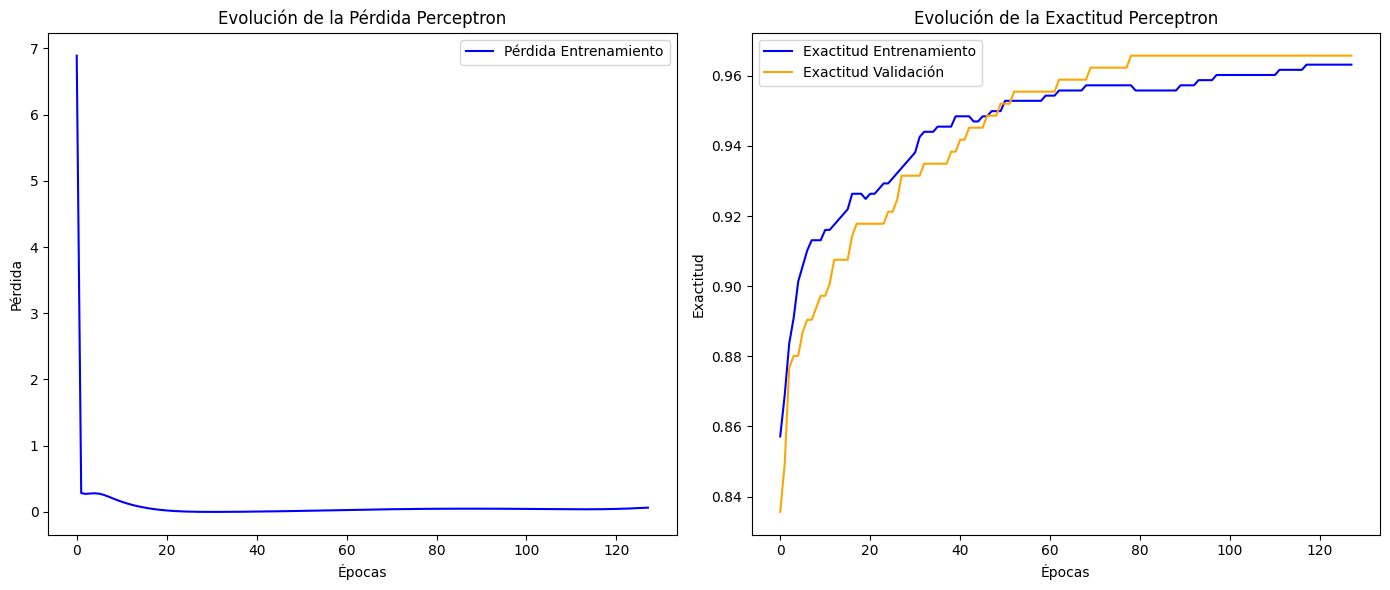

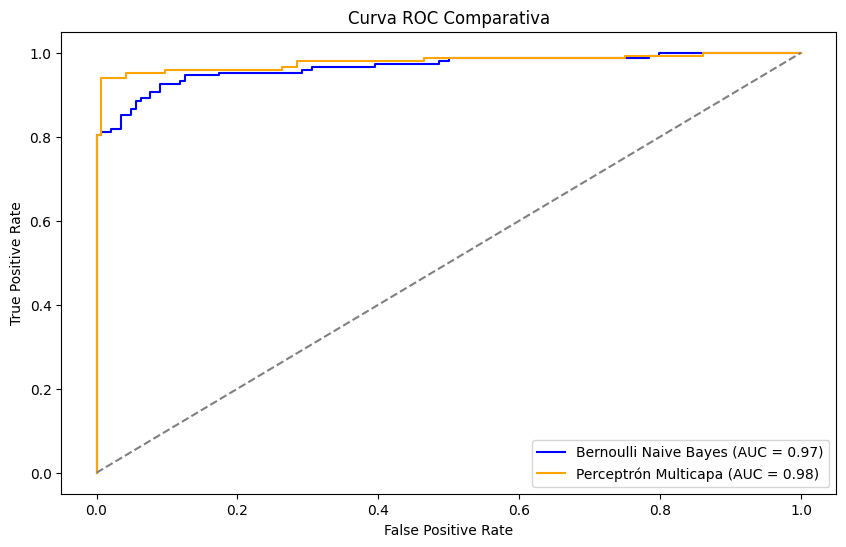

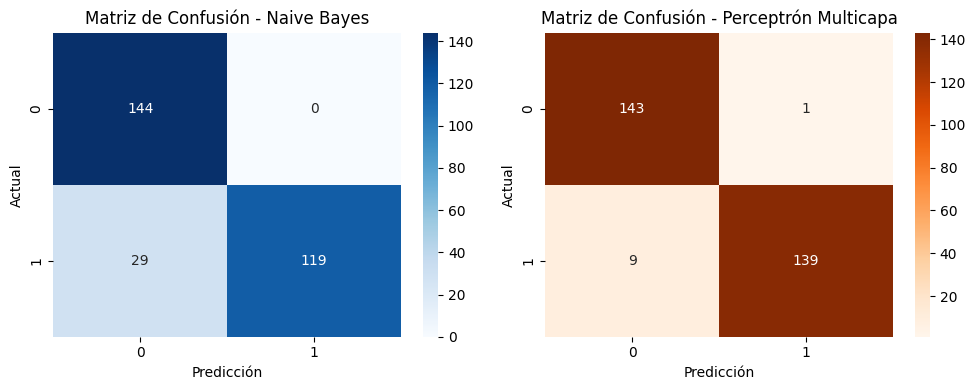

In [4]:
# Módulo 4: Evaluación de Modelos con Todas las Variables Originales (Bernoulli y Perceptrón)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sb
from nn import PerceptronMulticapa

# Paso 1: Cargar y procesar los datos
data = pd.read_csv('fraudes.csv', sep=';')

# Separar las características y la etiqueta
X = data.drop(columns=['Class']).values
y = data['Class'].values

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir las etiquetas a one-hot encoding para el Perceptrón Multicapa
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.3, stratify=y, random_state=42)

# Paso 2: Entrenar y evaluar Bernoulli Naive Bayes
# Nota: Para Bernoulli Naive Bayes, necesitamos las etiquetas originales, no el one-hot encoding.
model_nb = BernoulliNB()
model_nb.fit(X_train, np.argmax(y_train, axis=1))  # Convertir de one-hot a etiquetas normales

# Hacer predicciones y evaluar
y_pred_nb = model_nb.predict(X_test)
accuracy_nb = accuracy_score(np.argmax(y_test, axis=1), y_pred_nb)
precision_nb = precision_score(np.argmax(y_test, axis=1), y_pred_nb)
recall_nb = recall_score(np.argmax(y_test, axis=1), y_pred_nb)
f1_score_nb = f1_score(np.argmax(y_test, axis=1), y_pred_nb)
auc_nb = roc_auc_score(np.argmax(y_test, axis=1), model_nb.predict_proba(X_test)[:, 1])
conf_matrix_nb = confusion_matrix(np.argmax(y_test, axis=1), y_pred_nb)

print("Bernoulli Naive Bayes:")
print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1-Score: {f1_score_nb:.4f}")
print(f"AUC: {auc_nb:.4f}")

# Paso 3: Entrenar y evaluar el Perceptrón Multicapa
mlp = PerceptronMulticapa(features=X_train.shape[1], hidden=32)  # Inicializa con todas las características originales

# Crear listas para guardar la evolución de la pérdida y la exactitud
train_losses = []
train_accuracies = []
val_accuracies = []

epochs = 128
for i in range(epochs):
    for j in range(X_train.shape[0]):
        mlp.forward(X_train[[j]], y_train[[j]])
        mlp.backward(X_train[[j]], y_train[[j]])
    output, probs, accuracy, L = mlp.predict(X_train, y_train)
    train_losses.append(L)
    train_accuracies.append(accuracy)
    
    # Evaluación en los datos de validación
    _, _, val_accuracy, _ = mlp.predict(X_test, y_test)
    val_accuracies.append(val_accuracy)

# Evaluar el modelo Perceptrón Multicapa
output_mlp, probs_mlp, accuracy_mlp, _ = mlp.predict(X_test, y_test)
precision_mlp = precision_score(np.argmax(y_test, axis=1), output_mlp)
recall_mlp = recall_score(np.argmax(y_test, axis=1), output_mlp)
f1_score_mlp = f1_score(np.argmax(y_test, axis=1), output_mlp)
auc_mlp = roc_auc_score(np.argmax(y_test, axis=1), probs_mlp[:, 1])
conf_matrix_mlp = confusion_matrix(np.argmax(y_test, axis=1), output_mlp)

# Mostrar métricas finales en la consola
print("\nPerceptrón Multicapa:")
print(f"Accuracy: {accuracy_mlp:.4f}")
print(f"Precision: {precision_mlp:.4f}")
print(f"Recall: {recall_mlp:.4f}")
print(f"F1-Score: {f1_score_mlp:.4f}")
print(f"AUC: {auc_mlp:.4f}")

# Gráficos de la evolución de la pérdida y la exactitud
plt.figure(figsize=(14, 6))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, color='blue', label='Pérdida Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida Perceptron')
plt.legend()

# Gráfico de la exactitud
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, color='blue', label='Exactitud Entrenamiento')
plt.plot(range(epochs), val_accuracies, color='orange', label='Exactitud Validación')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.title('Evolución de la Exactitud Perceptron')
plt.legend()

plt.tight_layout()
plt.show()

# Curvas ROC
fpr_nb, tpr_nb, _ = roc_curve(np.argmax(y_test, axis=1), model_nb.predict_proba(X_test)[:, 1])
fpr_mlp, tpr_mlp, _ = roc_curve(np.argmax(y_test, axis=1), probs_mlp[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_nb, tpr_nb, label='Bernoulli Naive Bayes (AUC = {:.2f})'.format(auc_nb), color='blue')
plt.plot(fpr_mlp, tpr_mlp, label='Perceptrón Multicapa (AUC = {:.2f})'.format(auc_mlp), color='orange')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Comparativa')
plt.legend()
plt.show()

# Matrices de Confusión
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sb.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Naive Bayes')
plt.xlabel('Predicción')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sb.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión - Perceptrón Multicapa')
plt.xlabel('Predicción')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


In [5]:
# Módulo 5: Clasificador de Transacciones Perceptrón Multicapa con interfaz gráfica

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sb
from nn import PerceptronMulticapa
import joblib
import os
import tkinter as tk
from tkinter import filedialog, messagebox

# Función para entrenar el modelo
def train_model(data):
    # Separar las características y la etiqueta
    X = data.drop(columns=['Class']).values
    y = data['Class'].values

    # Escalar las características
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # Aquí estamos trabajando con arrays numpy, sin nombres de características

    # Convertir las etiquetas a one-hot encoding
    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y.reshape(-1, 1))

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.3, stratify=y, random_state=42)

    # Entrenar el Perceptrón Multicapa
    mlp = PerceptronMulticapa(features=X_train.shape[1], hidden=32)

    epochs = 128
    for i in range(epochs):
        for j in range(X_train.shape[0]):
            mlp.forward(X_train[[j]], y_train[[j]])
            mlp.backward(X_train[[j]], y_train[[j]])

    # Evaluar el modelo
    output_mlp, probs_mlp, accuracy_mlp, _ = mlp.predict(X_test, y_test)
    precision_mlp = precision_score(np.argmax(y_test, axis=1), output_mlp)
    recall_mlp = recall_score(np.argmax(y_test, axis=1), output_mlp)
    f1_score_mlp = f1_score(np.argmax(y_test, axis=1), output_mlp)
    auc_mlp = roc_auc_score(np.argmax(y_test, axis=1), probs_mlp[:, 1])

    print("\nPerceptrón Multicapa:")
    print(f"Accuracy: {accuracy_mlp:.4f}")
    print(f"Precision: {precision_mlp:.4f}")
    print(f"Recall: {recall_mlp:.4f}")
    print(f"F1-Score: {f1_score_mlp:.4f}")
    print(f"AUC: {auc_mlp:.4f}")

    return mlp, scaler

# Función v2 para procesar nuevas transacciones
def process_transactions(model, scaler, input_file, output_file):
    # Cargar los datos de entrada
    data = pd.read_csv(input_file, sep=';')
    
    # Verificar si la columna 'Class' existe antes de intentar eliminarla
    if 'Class' in data.columns:
        X = data.drop('Class', axis=1).values  # Convertimos el DataFrame a un array numpy para evitar nombres de características
    else:
        X = data.values  # Si no existe la columna 'Class', usamos el DataFrame tal cual

    X_scaled = scaler.transform(X)
    
    # Realizar predicciones
    output, probs, _, _ = model.predict(X_scaled, np.zeros((X_scaled.shape[0], 1)))  # Usamos zeros como placeholder para y
    predictions = output
    
    # Agregar las predicciones y las probabilidades al DataFrame original
    output_data = data.copy()
    output_data['Class'] = predictions
    output_data['Fraud_Probability'] = probs[:, 1]  # Columna con la probabilidad de ser fraude
    
    # Guardar los resultados en un nuevo archivo CSV
    output_file = os.path.splitext(output_file)[0] + ".csv"  # Cambiamos el nombre para reflejar que incluye probabilidades
    output_data.to_csv(output_file, sep=';', index=False)
    
    messagebox.showinfo("Procesamiento completado", f"Resultados guardados en {output_file}")
    print("\nClasificación terminada.")  # Mensaje final en la consola

# Función para manejar la selección del archivo y el procesamiento
def on_file_select():
    file_path = filedialog.askopenfilename(title="Seleccione el archivo CSV a procesar", filetypes=[("CSV files", "*.csv")])
    if file_path:
        output_file = os.path.splitext(file_path)[0] + "_procesado.csv"
        process_transactions(trained_model, trained_scaler, file_path, output_file)
        root.destroy()  # Cerrar la ventana después de seleccionar y procesar el archivo

# Cargar y entrenar el modelo
print("Cargando datos y entrenando el modelo...")
data = pd.read_csv('fraudes.csv', sep=';')
trained_model, trained_scaler = train_model(data)

# Configurar la interfaz gráfica
root = tk.Tk()
root.title("Procesador de Transacciones")
root.geometry("400x200")  # Ajustar el tamaño de la ventana

# Botón para seleccionar el archivo
select_button = tk.Button(root, text="Seleccionar Archivo CSV", command=on_file_select)
select_button.pack(pady=60)  # Ajustar el espacio alrededor del botón

# Ejecutar la interfaz gráfica
root.mainloop()


Cargando datos y entrenando el modelo...

Perceptrón Multicapa:
Accuracy: 0.9658
Precision: 0.9929
Recall: 0.9392
F1-Score: 0.9653
AUC: 0.9782

Clasificación terminada.
